<a href="https://colab.research.google.com/github/DHKing7/dahyunk/blob/main/Pothole_Segmentiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

In [ ]:
cd pothole600/

In [ ]:
pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/gautamchitnis/cocoapi.git (to revision cocodataset-master) to /tmp/pip-req-build-nnohi_qb
  Running command git clone -q https://github.com/gautamchitnis/cocoapi.git /tmp/pip-req-build-nnohi_qb
  Running command git checkout -b cocodataset-master --track origin/cocodataset-master
  Switched to a new branch 'cocodataset-master'
  Branch 'cocodataset-master' set up to track remote branch 'cocodataset-master' from 'origin'.


In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-q1pt8ww5
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-q1pt8ww5
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=265175 sha256=e7a2d4f266eb0765919d194bed99441e3f3ce20e27b09b745f32278503d08e89
  Stored in directory: /tmp/pip-ephem-wheel-cache-yhbfb6k5/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
%cd '/content'
!unzip  -qq '/content/drive/MyDrive/캡스톤디자인2/pothole600.zip'

/content


In [2]:
import os
import numpy as np
import torch
from PIL import Image
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path, transforms = None):
        self.path = path
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(path,"rgb"))))
        self.mask = list(sorted(os.listdir(os.path.join(path,"label"))))

    def __len__(self):
      return len(self.imgs)


# 마스크랑 이미지 파일명 같음
    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_mask = self.imgs[idx]
        img_path = os.path.join(self.path,'rgb', file_image)
        mask_path = os.path.join(self.path,"label", file_mask)
        img = Image.open(img_path).convert("RGB")
        
        mask = Image.open(mask_path)
        
        mask = np.array(mask)
        obj_ids = np.unique(mask)
     

        
        masks = mask == obj_ids[:, None, None]

        
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [5]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 146886, done.
remote: Counting objects: 100% (5897/5897), done.
remote: Compressing objects: 100% (405/405), done.
remote: Total 146886 (delta 5506), reused 5836 (delta 5468), pack-reused 140989
Receiving objects: 100% (146886/146886), 287.51 MiB | 12.02 MiB/s, done.
Resolving deltas: 100% (129822/129822), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [6]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []

    transforms.append(T.ToTensor())
    if train:

        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [18]:
cd content

/content


In [19]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = MyDataset('pothole600/testing/', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)

images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)   

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
os.getcwd()

'/content'

In [ ]:
# from google.colab import files
# src = list(files.upload().values())[0]
# open('engine.py','wb').write(src)


In [22]:
from engine import train_one_epoch, evaluate
import utils


dataset = MyDataset('pothole600/testing', get_transform(train=True))
dataset_test = MyDataset('pothole600/validation', get_transform(train=False))




torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])


data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 2

model = get_model_instance_segmentation(num_classes)

model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)


lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [25]:
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
  
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/65]  eta: 0:00:49  lr: 0.000083  loss: 2.1621 (2.1621)  loss_classifier: 0.4980 (0.4980)  loss_box_reg: 0.2377 (0.2377)  loss_mask: 1.3434 (1.3434)  loss_objectness: 0.0594 (0.0594)  loss_rpn_box_reg: 0.0236 (0.0236)  time: 0.7607  data: 0.3868  max mem: 2157
Epoch: [0]  [10/65]  eta: 0:00:17  lr: 0.000864  loss: 1.5991 (1.8700)  loss_classifier: 0.2643 (0.3042)  loss_box_reg: 0.1692 (0.1826)  loss_mask: 1.0410 (1.2943)  loss_objectness: 0.0586 (0.0534)  loss_rpn_box_reg: 0.0341 (0.0355)  time: 0.3103  data: 0.0445  max mem: 2436
Epoch: [0]  [20/65]  eta: 0:00:13  lr: 0.001644  loss: 1.0598 (1.4153)  loss_classifier: 0.1902 (0.2481)  loss_box_reg: 0.1791 (0.1943)  loss_mask: 0.6032 (0.9029)  loss_objectness: 0.0310 (0.0402)  loss_rpn_box_reg: 0.0277 (0.0298)  time: 0.2655  data: 0.0106  max mem: 2436
Epoch: [0]  [30/65]  eta: 0:00:09  lr: 0.002424  loss: 0.8514 (1.2360)  loss_classifier: 0.1255 (0.2014)  loss_box_reg: 0.1907 (0.1926)  loss_mask: 0.4513 (0.7780)  loss_ob

In [52]:
img, _ = dataset_test[3]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [53]:
prediction

[{'boxes': tensor([[4.6920e+00, 5.1505e+00, 4.0000e+02, 4.0000e+02],
          [2.9375e+02, 2.8227e+02, 3.8501e+02, 3.6010e+02],
          [2.5540e+02, 1.8117e-01, 4.0000e+02, 3.8206e+02],
          [2.1548e+02, 1.6682e+02, 3.1749e+02, 3.7083e+02]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0.0169, 0.0238, 0.0307,  ..., 0.0702, 0.0635, 0.0567],
            [0.0285, 0.0402, 0.0519,  ..., 0.1186, 0.1072, 0.0958],
            [0.0401, 0.0566, 0.0731,  ..., 0.1670, 0.1510, 0.1350],
            ...,
            [0.1198, 0.1690, 0.2182,  ..., 0.3733, 0.3375, 0.3017],
            [0.1083, 0.1528, 0.1973,  ..., 0.3375, 0.3052, 0.2728],
            [0.0968, 0.1366, 0.1764,  ..., 0.3018, 0.2729, 0.2440]]],
  
  
          [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            ...,
            [0.000

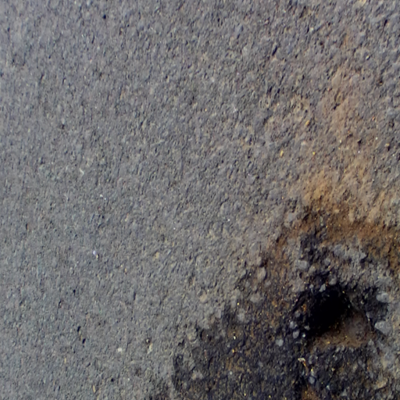

In [54]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

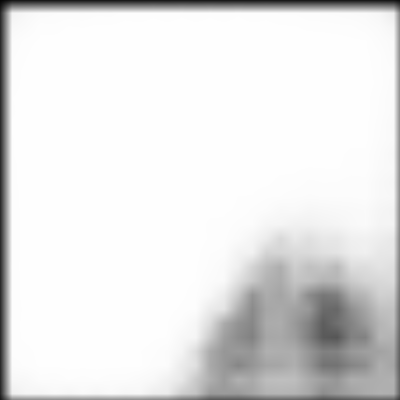

In [55]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())